本ノートブックでは実際には使っていないコードもオプションの１つとしてコメントアウトして掲載してある。これはGANの学習にはいくつものヒューリスティックスがあり、データセットやネットワークの構造に依存して取捨選択する必要があるためである。つまり、今回の問題設定でうまくいかなかったとしても他の問題設定ではうまくいく可能性が十分にある。

In [1]:
import os
os.environ["KERAS_BACKEND"] = "plaidml.keras.backend"
import keras
from keras import layers
import numpy as np

latent_dim = 100
height = 32
width = 32
channels = 3

#最適化アルゴリズム
#学習を安定させるために重みをclip＆weight decayを用いる
#識別者の学習ではRMSpropを用いたほうが良いとする事例もある
#またlrを非常に小さくする(0.00005以下)場合もある
#rmsp = keras.optimizers.RMSprop(lr=0.0008, clipvalue=1.0, decay=1e-8)
#識別者用＆敵対者用(DCGAN論文では両方Adam)
adam = keras.optimizers.Adam(lr=0.0002, beta_1=0.5, clipvalue=1.0, decay=1e-8)

#DC論文ではすべての重みを以下で初期化している
init = keras.initializers.RandomNormal(stddev=0.02)

Using plaidml.keras.backend backend.
INFO:plaidml:Opening device "metal_amd_radeon_pro_5300m.0"


In [2]:
#生成ネットワーク
generator_input = keras.Input(shape=(latent_dim,))
label = keras.Input(shape=(1,), dtype='int32')

#inputにlabelを追加する
label_embedding = layers.Flatten()(layers.Embedding(100, latent_dim)(label))
model_input = layers.multiply([generator_input, label_embedding])

#潜在変数を8x8 128-channels 特徴マップへ変換
x = layers.Dense(128 * 8 * 8,kernel_initializer=init)(model_input)
#この実装では生成ネットワークの活性化関数にLeakyReLUを用いるが
#代わりに以下のBatchNormalization＋LeRUを使う場合もある
#x = layers.BatchNormalization()(x)
#x = layers.Activation('relu')(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Reshape((8, 8, 128))(x)

#8x8 128-channelsを16x16 64-channelsの特徴マップへDeconvolutionで変換
#ストライドサイズで割り切れるカーネルサイズを使う
x = layers.Conv2DTranspose(64, 4, strides=2, padding='same')(x)
#x = layers.BatchNormalization()(x)
#x = layers.Activation('relu')(x)
x = layers.LeakyReLU(0.2)(x)

#16x16 64-channelsを32x32 64-channelsの特徴マップへDeconvolutionで変換
#ストライドサイズで割り切れるカーネルサイズを使う
x = layers.Conv2DTranspose(64, 4, strides=2, padding='same')(x)
#x = layers.BatchNormalization()(x)
#x = layers.Activation('relu')(x)
x = layers.LeakyReLU(0.2)(x)


#32x32 64-channelsを３２x32 3-channelsの特徴マップへ変換
#最後の出力の活性化関数はtanhを使う
x = layers.Conv2D(channels, 5, activation='tanh', padding='same')(x)

generator = keras.models.Model([generator_input, label], x)
generator.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 1, 100)       10000       input_2[0][0]                    
__________________________________________________________________________________________________
input_1 (InputLayer)            (None, 100)          0                                            
__________________________________________________________________________________________________
flatten_1 (Flatten)             (None, 100)          0           embedding_1[0][0]                
__________________________________________________________________________________________________
multiply_1

In [3]:
#識別ネットワーク
#LeakyReLU、Dropout、GlobalAveragedPoolingを使うのがポイント
discriminator_input = layers.Input(shape=(height, width, channels))
flat_input = layers.Flatten()(discriminator_input)

#inputにlabelを追加
label = keras.Input(shape=(1,), dtype='int32')
label_embedding = layers.Flatten()(layers.Embedding(100, height*width*channels)(label))
model_input = layers.multiply([flat_input, label_embedding])

x = layers.Conv2D(64, 5, strides=2,padding='same',kernel_initializer=init)(discriminator_input)
x = layers.LeakyReLU(0.2)(x)
x = layers.Dropout(0.3)(x)
x = layers.Conv2D(128, 5, strides=2,padding='same')(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Dropout(0.3)(x)
x = layers.Conv2D(256, 5, strides=2,padding='same')(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Dropout(0.3)(x)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(1, activation='sigmoid')(x)

discriminator = keras.models.Model([discriminator_input, label], x)
discriminator.summary()


discriminator_optimizer  = adam
discriminator.compile(optimizer=discriminator_optimizer, loss='binary_crossentropy')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 64)        4864      
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 16, 16, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 8, 128)         204928    
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 8, 8, 128)         0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 8, 8, 128)         0         
__________

In [23]:
#敵対的ネットワーク

label = keras.Input(shape=(1,), dtype='int32')

#識別ネットワークの学習を止めて
discriminator.trainable = False
#生成ネットワークの学習をする
gan_input = keras.Input(shape=(latent_dim,))
gan_output = discriminator([generator([gan_input, label]), label])
gan = keras.models.Model([gan_input, label], gan_output)

gan_optimizer = adam 
gan.summary()
gan.compile(optimizer=gan_optimizer, loss='binary_crossentropy')

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_37 (InputLayer)           (None, 100)          0                                            
__________________________________________________________________________________________________
input_36 (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
model_8 (Model)                 (None, 32, 32, 3)    1038931     input_37[0][0]                   
                                                                 input_36[0][0]                   
__________________________________________________________________________________________________
model_9 (Model)                 (None, 1)            1029505     model_8[3][0]                    
          

In [24]:
def label2onehot(labels, class_num):
    for i, label in enumerate(labels):
        vec = np.zeros(class_num)
        vec[label] = 1 
        if i == 0:
            onehot = vec
        else:
            onehot = np.vstack([onehot, vec])

    return onehot

In [44]:
import os
os.environ["KERAS_BACKEND"] = "plaidml.keras.backend"
from keras.preprocessing import image
from keras.datasets import cifar100
from tqdm import tqdm

#cifar100のダウンロード
(x_train, _), (x_test, y_test) = cifar100.load_data(label_mode='fine')
print(np.shape(x_train), np.shape(_), np.shape(x_test), np.shape(y_test))

(50000, 32, 32, 3) (50000, 1) (10000, 32, 32, 3) (10000, 1)


In [46]:
import os
os.environ["KERAS_BACKEND"] = "plaidml.keras.backend"
from keras.preprocessing import image
from keras.datasets import cifar100
from tqdm import tqdm

#cifar100のダウンロード
(x_train, y_train), (x_test, y_test) = cifar100.load_data(label_mode='fine')

#各ピクセルが[0,1]の値を取るように正規化
#x_train = x_train.astype('float32') / 255.
#x_train = x_train.reshape(x_train.shape + (1,))
#x_test = x_test.astype('float32') / 255.
#x_test = x_test.reshape(x_test.shape + (1,))

#one-hotエンコーディングしてlabelを生成
x_label = label2onehot(y_train, 100)
y_label = label2onehot(y_test, 100)

#生成者の出力をtanhとしたので
#各ピクセルが[-1,1]の値を取るように正規化
x_train = (x_train.astype('float32')-127.5)/ 127.5
#x_train = x_train.reshape(x_train.shape + (1,))
x_test = (x_test.astype('float32')-127.5)/ 127.5
x_test = x_test.reshape(x_test.shape + (1,))


In [48]:

#DCGAN論文で使われているバッチ数を使う
batch_size = 128


epochs=5
batchSize=batch_size
batchCount = x_train.shape[0] / batchSize
print ('Epochs:', epochs)
print ('Batch size:', batchSize)
print ('Batches per epoch:', batchCount)

sampled_labels = np.arange(0, 100).reshape(-1, 1)

# 学習のループ
for e in range(1, epochs+1):
    print('-'*15, 'Epoch %d' % e, '-'*15) 
    #tqdmを使うとプログレスバーが出るがColabだと不安定なので別で代用する
    #for _ in tqdm(range(int(batchCount))): 
    for i in range(int(batchCount)):
        print("\r{0}% [{1}]".format(int(i/(batchCount-1)*100), "*" * int((i+1)/batchCount*50)), end="")
        # 潜在空間からランダムにサンプリング
        random_latent_vectors = np.random.normal(size=(batch_size, latent_dim))

        imgs = x_train[i*batchSize : (i+1)*batchSize]
        labels = x_label[i*batchSize : (i+1)*batchSize]
        
        # データを生成する
        generated_images = generator.predict([random_latent_vectors, x_label[i]])

        # 観測データと生成データを識別するための入力データをつくる
        real_images = x_train[np.random.randint(0, x_train.shape[0], size=batchSize)]
        combined_images = np.concatenate([generated_images, real_images])

        # 観測データ(0)と生成データ(1)を識別するラベルをつくる
        labels = np.concatenate([np.ones((batch_size, 1)),
                             np.zeros((batch_size, 1))])
        
        # ランダムなノイズを加える
        # ラベルを1ではなく0.7-1.2, 0を0-0.3のようなソフトラベルにすることもある
        #labels += 0.05 * np.random.random(labels.shape)
        labels *= 0.9


        #識別ネットワークの学習
        d_loss = discriminator.train_on_batch(combined_images, labels)

        #潜在空間からサンプリング
        random_latent_vectors = np.random.normal(size=(batch_size, latent_dim))

        # すべてリアルなデータだと騙すためのラベル(y=0)を生成
        misleading_targets = np.zeros((batch_size, 1))

        # 生成ネットワークの学習
        # min -y*log(D(G(z)))
        a_loss = gan.train_on_batch(random_latent_vectors, misleading_targets)
        if i==int(batchCount)-1 :
            print("\n") 
            print('discriminator loss: %s' % (d_loss))
            print('adversarial loss  : %s' % (a_loss))
        
      

Epochs: 5
Batch size: 128
Batches per epoch: 390.625
--------------- Epoch 1 ---------------
0% []

TypeError: Cannot cast scalar from dtype('float64') to dtype('int32') according to the rule 'same_kind'

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


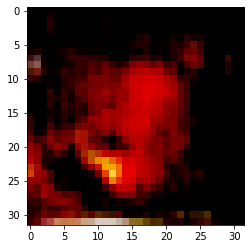

In [77]:
import matplotlib.pyplot as plt

#表示するサンプル数
examples=100
#潜在空間からサンプリング
noise = np.random.normal(0, 1, size=[examples, latent_dim])
#画像を生成
generatedImages = generator.predict(noise)

dim=(10, 10)
plt.figure(figsize=(10, 10))
for i in range(generatedImages.shape[0]):
    plt.subplot(dim[0], dim[1], i+1)
    plt.imshow(generatedImages[i].reshape(height, width, channels), interpolation='nearest', cmap='gray', vmin=-1, vmax=1)
    plt.axis('off')
plt.tight_layout()